# CONTROL DESIGN

This notebook illustrates the structure of your final project.

<img src="https://raw.github.com/joseph-hellerstein/advanced-controls-lectures/main/lectures/images/simple_feedback_nofilter.png "
     alt="Markdown Monster icon" 
     width="600" height="750"
     style="float: left; margin-right: 10px;" />

In [1]:
if False:
    !pip -q install controlSBML
    !pip -q install tellurium
    !pip -q install control

In [2]:
from controlSBML import ControlSBML, constants
from controlSBML.grid import Grid

import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
from typing import List, Optional

# Helpers

In [3]:
s = control.TransferFunction.s
TIMES = np.linspace(0, 5, 500)
WOLF_URL = constants.WOLF_URL

## plotStep

In [4]:
def plotStep(tf, title:str="", times=TIMES, xlim:Optional[list]=None, figsize=[5,5],
      is_plot=True):
    """
    Plots the step response of the transfer function.

    Args:
        tf - transfer function
    """
    _, ax = plt.subplots(1, 1, figsize=figsize)
    _, yv = control.step_response(tf, T=times)
    _ = ax.plot(times, yv)
    if xlim is not None:
        ax.set_xlim(xlim)
    _ = ax.set_title(title)
    if not is_plot:
        plt.close()

# TESTS
tf = control.TransferFunction([5], [1, 5])
plotStep(tf, is_plot=False, xlim=[0, 3])
print("OK!")

OK!


## complex_magnitude

In [5]:
def complex_magnitude(z):
    return (z.real**2 + z.imag**2)**0.5

## ppComplex

In [6]:
def ppComplex(complexes:np.ndarray, round_digits=3)->str:
    """
    Constructs a pretty print representation of a complex number.
    """
    complexes = np.array(complexes)
    complexes = complexes.flatten()
    if not isinstance(complexes, list):
        complexes = [complexes]
    results = []
    if isinstance(complexes[0], np.ndarray):
        complexes = complexes[0]
    for cmpx in complexes:
        try:
            if np.imag(cmpx) == 0:
                results.append(str(round(np.real(cmpx), round_digits)))
            else:
                 results.append(str(round(np.real(cmpx), round_digits)) + "+" + str(round(np.imag(cmpx), round_digits)) + "j")
        except:
            import pdb; pdb.set_trace()
    return ", ".join(results)

# Tests
result = ppComplex((-1.9999999999999998+0j))
result = ppComplex([3+2j, 4])
assert("j" in result)
print("OK!")

OK!


## plotRootLocusWithGains

In [7]:
def plotRootLocusWithGains(open_loop_transfer_function:control.TransferFunction,
      gains:List[float],
      xlim:Optional[np.ndarray]=None,
      title:Optional[str]=None,
      ylim:Optional[np.ndarray]=None,
      is_annotate:bool=True,
      markersize_multiplier:float=100,
      figsize=(5, 5),
      ax=None,
      is_plot:bool=True)->plt.axes:
    """
    Constructs a root locus plot with red hexagons for closed loop poles at different gains.
    Poles at specific gains are indicated by hexigon markers.

    Args:
        open_loop_transfer_function
        gains
        xlim: limits on the axis
        size_multiplier: multiplies by gain to get size of hexagon that marks the pole
        figsize: width and height of figure
        is_annotate: Annotate gain hexigons with gain values
    """
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    # Plot the root locus
    _ = control.root_locus(open_loop_transfer_function, grid=False, plot=True, xlim=xlim,
          ylim=ylim, ax=ax)
    # Construct the title
    if title is None:
        poles = open_loop_transfer_function.poles()
        zeros = open_loop_transfer_function.zeros()
        title = ""
        if len(poles) > 0:
            title += f"FFL poles: {ppComplex(poles)}  "
        if len(zeros) > 0:
            title += f"FFL zeros: {ppComplex(zeros)}"
    ax.set_title(title)
    # Add points for closed loop poles
    for gain in gains:
        closed_loop_transfer_function = control.feedback(gain*open_loop_transfer_function)
        poles = closed_loop_transfer_function.poles()
        xv = []
        yv = []
        for pole in poles:
            xv.append(pole.real)
            yv.append(pole.imag)
        if is_annotate:
            annotation = str(gain)
        else:
            annotation = ""
        ax.scatter(xv, yv, s=markersize_multiplier*gain, marker="h", color="r")
        [ ax.annotate(annotation, (xv[i], yv[i]), color='blue', rotation=25)
             for i in range(len(poles))]
        arrowprops=dict(facecolor='black', shrink=0.05)
    # Plot at zero
    ax.plot([0, 0], [-10, 10], color="grey", linestyle="--")
    #
    if not is_plot:
        plt.close()
        ax = None
    return ax

# Tests
tf = control.zpk([1], [-1, -2], [1])
plotRootLocusWithGains(tf, [0.2, 0.5], markersize_multiplier=200, ylim=[-3, 3], xlim=[-3.5, 0], is_annotate=True,
      figsize=(2, 2), is_plot=False)
print("OK!")

OK!


# 1. Control objective

The biological problem we address is controlling the concentration of pyruvate, ``s5`` in the Wolf model of glycolytic oscillations.  Our control objectives are:
* Regulate ``pyruvate` to a setpoint
* Fast settling times
* Avoid oscillations

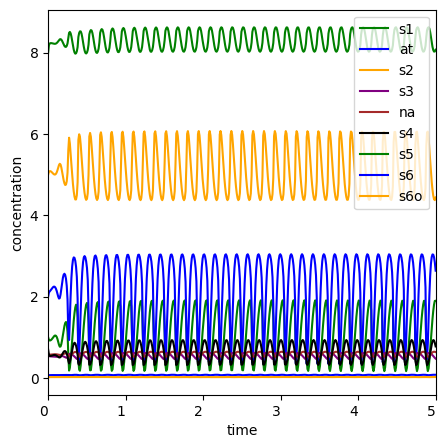

// Created by libAntimony v2.15.0
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

In [8]:
CTLSB = ControlSBML(WOLF_URL, times=TIMES)
_ = CTLSB.plotModel()
print(CTLSB.getAntimony())

# 2. System definition

The system we analyze has the following characteristics:
1. SBML model: BIOMDELS 206
1. output: na (NADP)
1. input: s5 (pyruvate)
1. directional effect of the input on the output: increasing (See below.)
1. operating region for the input: [0.5, 1] (See below.)
1. range of outputs that can be achieved: [8, 11]  (See below.)

In [9]:
# Global variables
INPUT_NAME = "na"
OUTPUT_NAME = "s5"
CTLSB = ControlSBML(WOLF_URL, input_name=INPUT_NAME, output_name=OUTPUT_NAME, times=TIMES)

The input and output seem to be related within the simulation. We can learn more by controlling the input to see the effect on the output and, from there, determining the operating point and time constants of the system.

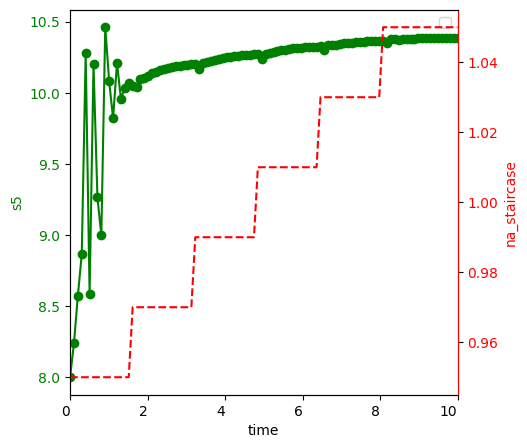

In [10]:
_ = CTLSB.plotStaircaseResponse(initial_value=0.95, final_value=1.05, times=np.linspace(0, 10, 100))

In [11]:
OPERATING_REGION = {'initial_value': 0.95, 'final_value': 1.05, 'times': np.linspace(0,10, 100)}

Clearly, the effect of the input ``na`` causes the output ``s5`` to increase. However, there is an initial transient, sustained oscillations, and a value of ``na`` that is larger than 1.0 has not effect. The output range is [8, 11.5].

The initial transient is likely related to initial conditions set by the model. We can ignore this since they disappear after a few hundred seconds.

# 3. System Identification

System identification describes the system as a transfer function for the operating point specified in system definition. In our system, the input is ``na`` and the output is ``s5``. The input is varied over the operating region of [0.5, 1]. The method ``plotTransferFunctionFit`` estimates to transfer function and plots the fit.

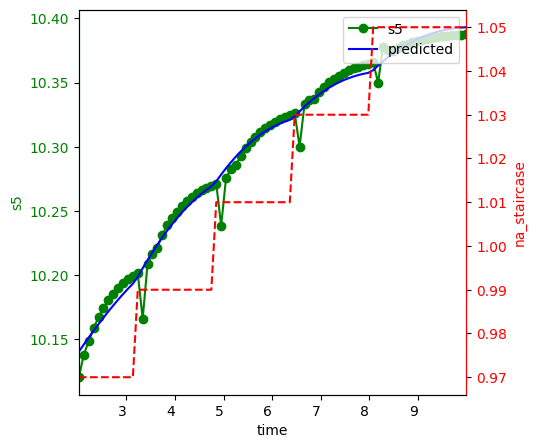

In [12]:
_ = CTLSB.plotTransferFunctionFit(num_zero=1, num_pole=2, fit_start_time=2,
      **OPERATING_REGION)

How to proceed from here:
1. Don't fit the initial transient. ``fit_start_time = 2``
2. Increase the number of poles.
3. Increase the number of zeroes.

In [13]:
WOLF_OLTF = CTLSB.getOpenLoopTransferFunction()
WOLF_OLTF

TransferFunction(array([1.15254174, 0.65100612]), array([0.73385185, 0.51414593, 0.32649757]))

In [14]:
WOLF_OLTF.poles(), WOLF_OLTF.zeros()

(array([-0.35030635+0.56762209j, -0.35030635-0.56762209j]),
 array([-0.56484385+0.j]))

# 4. Theory-based design

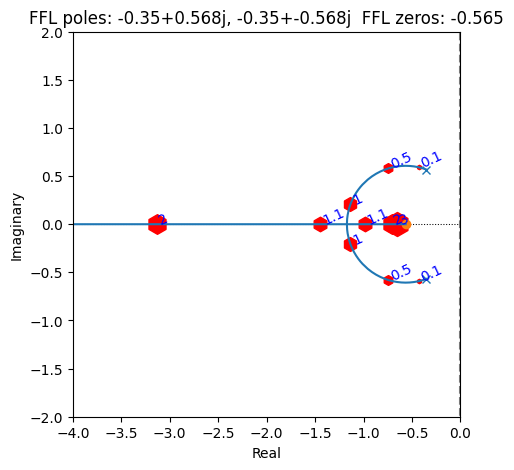

In [15]:
# P-control
_ = plotRootLocusWithGains(WOLF_OLTF, gains=[0.1, 0.5, 1, 1.1, 2, 3], xlim=[-4, 0], ylim=[-2, 2])

PI control. So
\begin{eqnarray}
C(s) &=& \frac{k_I + s k_P}{s} \\
 & = & k_P \frac{r_{IP} + s}{s}
\end{eqnarray}

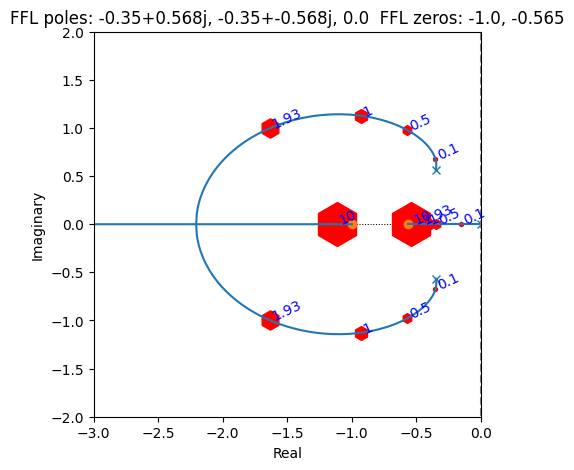

In [16]:
rIP = 1
s = control.TransferFunction.s
control_tf = control.TransferFunction([1, rIP], [1, 0])
_ = plotRootLocusWithGains(control_tf*WOLF_OLTF, gains=[0.1, 0.5, 1, 1.93, 10], xlim=[-3, 0], ylim=[-2, 2])

**Analysis of theory-based design**
1. We have two imaginary open loop poles and a pole at zero from I-control. So, we expect that a larger $k_P$ will do better.
1. We have an open loop zero at -0.565 from system identification. This is likely the smallest real, dominant pole that we can get.

# 5. Final design


Here, we build a closed loop system where the open loop is the SBML model of the simulated system. We use a PI controller. We examine both the output response and the value of the input. The latter is to ensure that we are within the operating region.

## Start from theory-based design

In [17]:
NUM_PROCESS = 1 # Number of processes to use in grid design. Colab can't handle > 1.

Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.05934 and h = 1.88871e-15, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.964224 and h = 2.44287e-18, the corrector convergence test failed repeatedly or with |h| = hmin.
 11%|████▌                                     | 11/100 [00:01<00:09,  9.27it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.983322 and h = 5.85274e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.02126 and h = 4.64113e-18, the corrector convergence test failed repeatedly or with |h| = hmin.
 21%|████████▊                                 | 21/100 [00:02<00:06, 11.63it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.52798 and h = 1.30192e-18, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.30076 and h = 1.52304e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
 27%|███████████▎                              | 27/100 [00:03<00:05, 12.44it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.09033 and h = 4.01442e-23, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.12931 and h = 4.67288e-26, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.872296 and h = 1.27676e-23, the corrector convergence test failed repeatedly or with |h| = hmin.
 31%|█████████████                             | 31/100 [00:03<00:05, 12.28it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.04163 and h = 3.94493e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.907281 and h = 2.75416e-17, the corrector convergence test failed repeatedly or with |h| = hmin.
 41%|█████████████████▏                        | 41/100 [00:04<00:04, 13.14it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.57667 and h = 1.25922e-18, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.46912 and h = 8.7298e-18, the corrector convergence test failed repeatedly or with |h| = hmin.
 47%|███████████████████▋                      | 47/100 [00:04<00:03, 13.26it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.19791 and h = 1.74962e-20, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.05119 and h = 2.50757e-17, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.06961 and h = 1.26379e-17, the corrector convergence test failed repeatedly or with |h| = hmin.
 51%|█████████████████████▍                    | 51/100 [00:04<00:03, 13.00it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 2.45364 and h = 5.80284e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.86123 and h = 1.04776e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
 55%|███████████████████████                   | 55/100 [00:05<00:03, 12.82it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.50186 and h = 1.4503e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.38048 and h = 4.19765e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.16442 and h = 8.93765e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.02299 and h = 6.41315e-18, the corrector convergence test failed repeatedly or with |h| = hmin.
 59%|████████████████████████▊                 | 59/100 [00:05<00:03, 12.51it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.995599 and h = 4.44954e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 6.12629 and h = 1.52727e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
 61%|█████████████████████████▌                | 61/100 [00:05<00:03, 12.37it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 4.12233 and h = 7.12775e-24, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 3.07454 and h = 4.61956e-23, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 2.35719 and h = 4.51977e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.84391 and h = 1.55841e-18, the corrector convergence test failed repeatedly or with |h| = hmin.
 65%|███████████████████████████▎              | 65/100 [00:06<00:02, 12.18it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.70521 and h = 6.56278e-16, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.30184 and h = 1.08912e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
 67%|████████████████████████████▏             | 67/100 [00:06<00:02, 12.42it/s]

CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.13635 and h = 2.59422e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.18941 and h = 4.49044e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.974784 and h = 9.12119e-22, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 6.1307 and h = 7.50202e-24, the corrector convergence test failed repeatedly or with |h| = hmin.
 71%|█████████████████████████████▊            | 71/100 [00:06<00:02, 12.06it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 4.00887 and h = 2.84995e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 2.99935 and h = 2.00637e-18, the corrector convergence test failed repeatedly or with |h| = hmin.
 73%|██████████████████████████████▋           | 73/100 [00:06<00:02, 12.16it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 2.6726 and h = 4.23713e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.81397 and h = 7.89004e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.678 and h = 7.68427e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.28455 and h = 5.51633e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
 77%|████████████████████████████████▎         | 77/100 [00:07<00:01, 11.75it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.10995 and h = 1.10441e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.18217 and h = 5.41435e-22, the corrector convergence test failed repeatedly or with |h| = hmin.
 79%|█████████████████████████████████▏        | 79/100 [00:07<00:01, 11.90it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.989437 and h = 1.44725e-17, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 5.79592 and h = 7.56415e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 4.22234 and h = 3.89684e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 2.98759 and h = 7.0001e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
 83%|██████████████████████████████████▊       | 83/100 [00:07<00:01, 12.16it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 2.2815 and h = 8.56319e-23, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.75872 and h = 1.06422e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
 85%|███████████████████████████████████▋      | 85/100 [00:07<00:01, 12.25it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.68062 and h = 4.3014e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.27908 and h = 6.02971e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.11509 and h = 3.91928e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.14344 and h = 4.64745e-16, the error test failed repeatedly or with |h| = hmin.
 89%|█████████████████████████████████████▍    | 89/100 [00:07<00:00, 12.70it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.950233 and h = 2.43181e-25, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 5.77801 and h = 3.90653e-17, the corrector convergence test failed repeatedly or with |h| = hmin.
 91%|██████████████████████████████████████▏   | 91/100 [00:08<00:00, 12.49it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 3.88746 and h = 6.64439e-25, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 2.97024 and h = 5.87085e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 2.29905 and h = 4.57392e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 2.07375 and h = 1.72013e-16, the corrector convergence test failed repeatedly or with |h| = hmin.
 95%|███████████████████████████████████████▉  | 95/100 [00:08<00:00, 12.58it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.64207 and h = 1.80538e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.25966 and h = 2.55236e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
 97%|████████████████████████████████████████▋ | 97/100 [00:08<00:00, 12.47it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.09601 and h = 2.06218e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.14806 and h = 2.57344e-18, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 1.00198 and h = 3.53834e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.30it/s]


CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


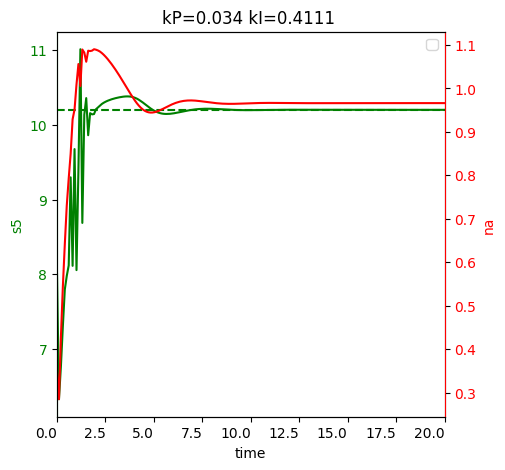

In [18]:
grid = Grid()
grid.addAxis("kP", min_value=0.001, max_value=0.1, num_coordinate=10)
grid.addAxis("kI", min_value=0.1, max_value=0.5, num_coordinate=10)
_ = CTLSB.plotGridDesign(grid, title="", times=np.linspace(0, 20, 200), setpoint=10.2, num_process=NUM_PROCESS)

The convergence failures likely mean that the actual system cannot handle the large values of $k_P, k_I$ that we're using. So, we need to back off on these.

## Manual tuning

In [19]:
grid = Grid()
grid.addAxis("kP", min_value=0.1, max_value=0.1, num_coordinate=10)
grid.addAxis("kI", min_value=0.1, max_value=0.1, num_coordinate=10)
_ = CTLSB.plotGridDesign(grid, title="", times=np.linspace(0, 200, 2000), setpoint=10.2)

Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 5.59343 and h = 6.95259e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 5.59343 and h = 6.95259e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 5.59343 and h = 6.95259e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 5.59343 and h = 6.95259e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 5.59343 and h = 6.95259e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: A

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep 

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** No design found!



Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 163.818 and h = 2.70515e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 131.162 and h = 1.39139e-18, the corrector convergence test failed repeatedly or with |h| = hmin.
 65%|███████████████████████████▎              | 65/100 [00:08<00:05,  6.30it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 93.4081 and h = 1.47645e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 82.1021 and h = 3.29477e-18, the corrector convergence test failed repeatedly or with |h| = hmin.
 68%|████████████████████████████▌             | 68/100 [00:09<00:04,  6.73it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 76.3127 and h = 7.18298e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 65.4876 and h = 7.28231e-19, the corrector convergence test failed repeatedly or with |h| = hmin.
 70%|█████████████████████████████▍            | 70/100 [00:09<00:04,  7.27it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 158.364 and h = 1.34691e-18, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 127.803 and h = 1.32533e-17, the corrector convergence test failed repeatedly or with |h| = hmin.
 75%|███████████████████████████████▌          | 75/100 [00:10<00:03,  6.99it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 91.3614 and h = 4.85506e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
 79%|█████████████████████████████████▏        | 79/100 [00:10<00:02,  8.67it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 63.0739 and h = 1.97153e-22, the corrector convergence test failed repeatedly or with |h| = hmin.
 81%|██████████████████████████████████        | 81/100 [00:11<00:02,  7.35it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 154.887 and h = 3.99768e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 122.947 and h = 2.4909e-18, the corrector convergence test failed repeatedly or with |h| = hmin.
 85%|███████████████████████████████████▋      | 85/100 [00:11<00:02,  6.52it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 102.287 and h = 6.05156e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 90.755 and h = 2.5896e-20, the corrector convergence test failed repeatedly or with |h| = hmin.
 87%|████████████████████████████████████▌     | 87/100 [00:12<00:01,  6.89it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 68.5111 and h = 2.74824e-22, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 61.3142 and h = 1.201e-16, the corrector convergence test failed repeatedly or with |h| = hmin.
 90%|█████████████████████████████████████▊    | 90/100 [00:12<00:01,  7.77it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 199.311 and h = 1.32626e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
 93%|███████████████████████████████████████   | 93/100 [00:12<00:00,  7.26it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 119.387 and h = 1.80893e-26, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 99.476 and h = 4.98986e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
 98%|█████████████████████████████████████████▏| 98/100 [00:13<00:00,  8.47it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 59.6358 and h = 4.4957e-21, the corrector convergence test failed repeatedly or with |h| = hmin.
100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.39it/s]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


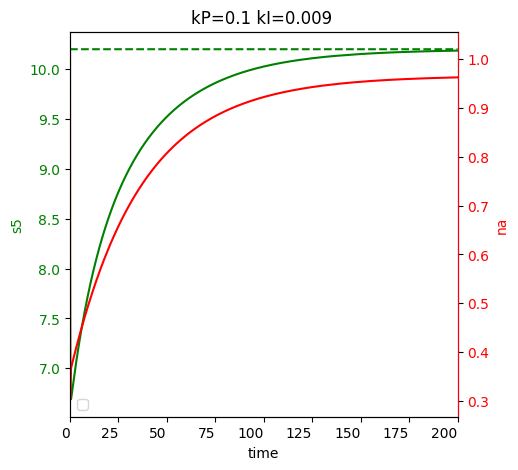

In [20]:
grid = Grid()
grid.addAxis("kP", min_value=0.01, max_value=0.1, num_coordinate=10)
grid.addAxis("kI", min_value=0.001, max_value=0.01, num_coordinate=10)
#_ = CTLSB.plotDesign(kP_spec=0.55, kI_spec=True, title="", times=np.linspace(0, 1, 100), setpoint=10.2, num_process=NUM_PROCESS)
_ = CTLSB.plotGridDesign(grid, title="", times=np.linspace(0, 200, 2000), setpoint=10.2, num_process=NUM_PROCESS)

# 6. Evaluate the final design

1. We need very small $k_P, k_I$ to make the system stable.
2. From the theory-based design, we see that this means that poles are near 0 and so the closed loop system is very slow.
3. The theory-based design provided a framework for tuning, but not reasonable estimates of the actual design parameters.